In [36]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [37]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [38]:
# Import necessary libraries
import pandas as pd  # Data processing
import re  # Handle regular expressions for text cleaning
import numpy as np  # Numerical calculations
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Statistical data visualization
from wordcloud import WordCloud  # Generate word clouds
import nltk  # Natural language processing
from nltk.corpus import stopwords  # Stopwords
from nltk.stem import WordNetLemmatizer  # Lemmatization
from sklearn.decomposition import NMF, LatentDirichletAllocation  # Topic modeling (NMF, LDA)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer  # Text vectorization
from sklearn.cluster import KMeans  # K-Means clustering, used to select the optimal number of topics



In [82]:
### Text preprocessing, mainly removing stopwords and performing lemmatization (similar to stemming),
### making text data more suitable for machine learning and natural language processing (NLP) tasks

# Download NLTK resources
nltk.download("stopwords")  # Download the English stopwords list
nltk.download("wordnet")    # Download the lemmatization dictionary

# Load the set of stopwords and initialize the lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to /Users/os/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/os/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [83]:

# Read data
df = pd.read_csv("outputs/combined_jobs_dataset.csv")

# Define a text cleaning function
def clean_text(text):
    """
    Clean text data by:
    1. Converting to lowercase
    2. Removing HTML tags
    3. Keeping only English letters
    4. Lemmatizing
    5. Removing stopwords
    """
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-z\s]', '', text)  # Keep only letters and spaces
    words = text.split()  # Split into a list of words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatize & remove stopwords
    return " ".join(words)  # Join back into a single string

# Clean the "Job Description" column
df["Cleaned_Description"] = df["Job Description"].fillna("").apply(clean_text)



## **TF-IDF 向量化解释**

### **1. 什么是 TF-IDF？**
TF-IDF（Term Frequency-Inverse Document Frequency，词频-逆文档频率）是一种文本特征提取方法，用于衡量某个词在文档中的重要性。

- **TF（词频）**：某个词在文档中出现的频率。
- **IDF（逆文档频率）**：衡量该词在整个语料库中的区分度。
- **TF-IDF 计算公式**：
  $$
  TF-IDF(t) = TF(t) \times IDF(t)
  $$
  - **高 TF-IDF**：表示该词对该文档的重要性高。
  - **低 TF-IDF**：表示该词在所有文档中都常见，影响力较低。

### **2. 代码解析**
```python
vectorizer = TfidfVectorizer(stop_words="english", max_features=3000, min_df=5, ngram_range=(1,2))
X = vectorizer.fit_transform(df["Cleaned_Description"])
```

### **3. 关键参数解析**
| 参数 | 作用 |
|------|------|
| `stop_words="english"` | 去除常见停用词（如 "the", "is", "and"）。 |
| `max_features=3000` | 仅保留最重要的 3000 个单词，提高计算效率。 |
| `min_df=5` | 过滤掉少于 5 篇文档中出现的低频词。 |
| `ngram_range=(1,2)` | 提取单个单词（unigram）和双词短语（bigram）。 |

### **4. 作用与意义**
✅ **将文本转换为数值矩阵**，适用于机器学习模型。  
✅ **突出关键单词，削弱常见单词的影响**。  
✅ **优化 NMF 主题建模 & 机器学习算法的输入特征**。

💡 **示例**：
- 输入文本：`"data analysis machine learning ai python"`
- 提取特征：`["data", "machine learning", "python", "ai"]`
- 生成 TF-IDF 矩阵，用于主题建模或分类任务。
```

/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


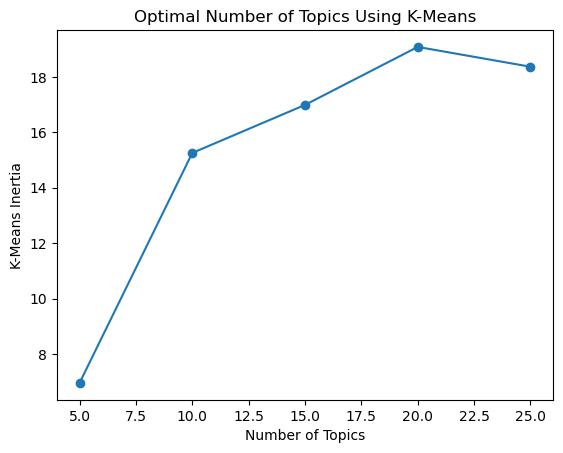

In [99]:
# **TF-IDF Vectorization**
vectorizer = TfidfVectorizer(stop_words="english", max_features=3000, min_df=5, ngram_range=(1,2))
X = vectorizer.fit_transform(df["Cleaned_Description"])  # Convert text into a TF-IDF matrix

# **Choose the Best Number of Topics (K-Means Evaluation)**
scores = []
for k in range(5, 30, 5):  # Evaluate different numbers of topics
    nmf = NMF(n_components=k, random_state=42)
    W = nmf.fit_transform(X)
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(W)  # Perform K-Means clustering on the NMF results
    scores.append(kmeans.inertia_)  # Record the K-Means clustering error

# **Plot the K-Means Inertia Curve**
plt.plot(range(5, 30, 5), scores, marker="o")
plt.xlabel("Number of Topics")  # X-axis: number of topics
plt.ylabel("K-Means Inertia")    # Y-axis: K-Means inertia
plt.title("Optimal Number of Topics Using K-Means")  # Title
plt.show()  # Display the plot


In [101]:
# **Set the Best Number of Topics**
best_n = 20
nmf_model = NMF(n_components=best_n, random_state=42)
W = nmf_model.fit_transform(X)  # Retrieve the document-topic matrix
H = nmf_model.components_        # Retrieve the topic-word matrix

# **Extract Keywords for Each Topic**
terms = vectorizer.get_feature_names_out()
topic_keywords = {}

for topic_idx, topic in enumerate(H):  # Iterate through each topic
    topic_words = [terms[i] for i in topic.argsort()[:-11:-1]]  # Select the top 10 words with the highest weights
    topic_keywords[f"Topic {topic_idx}"] = topic_words
    print(f"Topic {topic_idx}: {topic_words}")  # Print the topic keywords


Topic 0: ['ability', 'skill', 'work', 'strong', 'able', 'excellent', 'required', 'communication', 'skill ability', 'written']
Topic 1: ['data', 'locate', 'using statistical', 'statistical', 'analyze', 'interpret', 'database', 'report', 'package', 'information']
Topic 2: ['learning', 'machine', 'machine learning', 'model', 'scientist', 'algorithm', 'data scientist', 'science', 'data', 'experience']
Topic 3: ['status', 'employment', 'protected', 'gender', 'disability', 'veteran', 'applicant', 'law', 'origin', 'national']
Topic 4: ['data', 'analytics', 'analysis', 'business', 'visualization', 'insight', 'tool', 'data visualization', 'dashboard', 'experience']
Topic 5: ['data', 'data quality', 'governance', 'quality', 'data governance', 'data management', 'enterprise', 'management', 'standard', 'metadata']
Topic 6: ['research', 'data', 'analysis', 'health', 'program', 'study', 'statistical', 'staff', 'university', 'clinical']
Topic 7: ['data', 'analyst', 'client', 'data analyst', 'job', 'c

/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


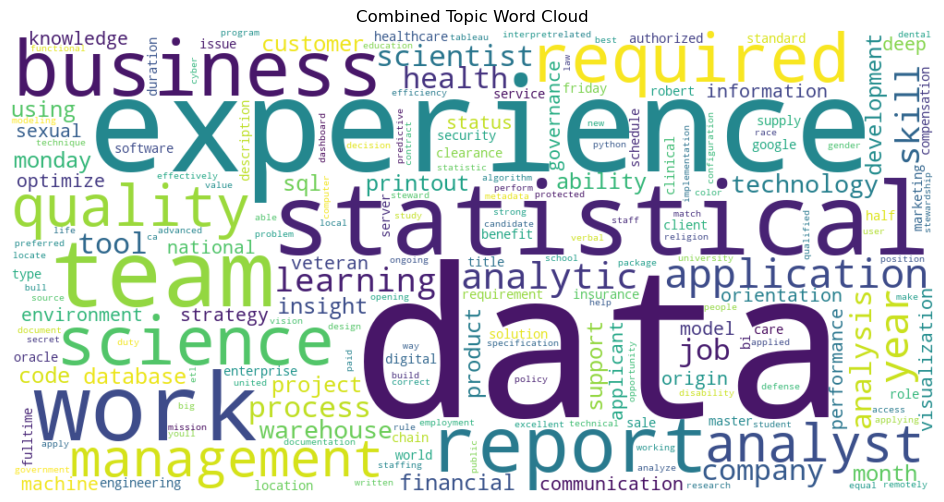

In [103]:
# **Combine all topic keywords to create a consolidated word cloud**
all_topic_words = " ".join([" ".join([terms[i] for i in topic.argsort()[:-21:-1]]) for topic in H])

# **Generate the word cloud**
wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(all_topic_words)

# **Plot the word cloud**
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide the axes
plt.title("Combined Topic Word Cloud")  # Title
plt.show()  # Display the plot


In [69]:
# **Assign the Most Likely Topic to Each Job**
df["Extracted_Skills"] = W.argmax(axis=1)
df


,Job Title,Job Description,City,State,job_state,same_state,job_simp,seniority,Easy Apply,Competitors,...,hadoop,spark,aws,tableau,big_data,Salary_Min,Salary_Max,Salary_Avg,Cleaned_Description,Extracted_Skills
0,Sr Data Scientist,Description\n\nThe Senior Data Scientist is re...,New York,NY,NY,1.0,data scientist,senior,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,137000.0,171000.0,154000.0,description senior data scientist responsible ...,3
1,Data Scientist,"Secure our Nation, Ignite your Future\n\nJoin ...",Chantilly,VA,VA,0.0,data scientist,na,NaN,NaN,...,1.0,0.0,0.0,0.0,1.0,137000.0,171000.0,154000.0,secure nation ignite future join top informati...,3
2,Data Scientist,Overview\n\n\nAnalysis Group is one of the lar...,Boston,MA,MA,1.0,data scientist,na,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,137000.0,171000.0,154000.0,overview analysis group one largest internatio...,17
3,Data Scientist,JOB DESCRIPTION:\n\nDo you have a passion for ...,Newton,MA,MA,0.0,data scientist,na,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,137000.0,171000.0,154000.0,job description passion data machine learning ...,2
4,Data Scientist,Data Scientist\nAffinity Solutions / Marketing...,New York,NY,NY,1.0,data scientist,na,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,137000.0,171000.0,154000.0,data scientist affinity solution marketing clo...,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2908,RQS - IHHA - 201900004460 -1q Data Security An...,Maintains systems to protect data from unautho...,Denver,CO,NaN,NaN,NaN,NaN,-1,-1,...,NaN,NaN,NaN,NaN,NaN,78000.0,104000.0,91000.0,maintains system protect data unauthorized use...,10
2909,Senior Data Analyst (Corporate Audit),Position:\nSenior Data Analyst (Corporate Audi...,Centennial,CO,NaN,NaN,NaN,NaN,-1,"Avnet, Ingram Micro, Tech Data",...,NaN,NaN,NaN,NaN,NaN,78000.0,104000.0,91000.0,position senior data analyst corporate audit j...,4
2910,"Technical Business Analyst (SQL, Data analytic...","Title: Technical Business Analyst (SQL, Data a...",Denver,CO,NaN,NaN,NaN,NaN,-1,-1,...,NaN,NaN,NaN,NaN,NaN,78000.0,104000.0,91000.0,title technical business analyst sql data anal...,9
2911,"Data Analyst 3, Customer Experience",Summary\n\nResponsible for working cross-funct...,Centennial,CO,NaN,NaN,NaN,NaN,-1,-1,...,NaN,NaN,NaN,NaN,NaN,78000.0,104000.0,91000.0,summary responsible working crossfunctionally ...,4


In [105]:
# **Run LDA for Comparison**
lda_model = LatentDirichletAllocation(n_components=best_n, random_state=42)
lda_W = lda_model.fit_transform(X)
lda_H = lda_model.components_

print("\nLDA Topics:")
for topic_idx, topic in enumerate(lda_H):  # Iterate through each LDA topic
    topic_words = [terms[i] for i in topic.argsort()[:-11:-1]]  # Select the top 10 words with the highest weights
    print(f"Topic {topic_idx}: {topic_words}")  # Print the LDA topic keywords



LDA Topics:
Topic 0: ['responsibility data', 'develop new', 'permanent', 'marketplace', 'food', 'mining segmentation', 'pet', 'expertise regarding', 'bioinformatics', 'information attention']
Topic 1: ['data', 'locate', 'using statistical', 'statistical', 'interpret', 'analyze', 'database', 'report', 'statistical efficiency', 'optimize statistical']
Topic 2: ['responsibility data', 'develop new', 'permanent', 'marketplace', 'food', 'mining segmentation', 'pet', 'expertise regarding', 'bioinformatics', 'information attention']
Topic 3: ['responsibility data', 'develop new', 'permanent', 'marketplace', 'food', 'mining segmentation', 'pet', 'expertise regarding', 'bioinformatics', 'information attention']
Topic 4: ['bull', 'erp', 'migration', 'responsibility data', 'attention accuracy', 'commission', 'data analyze', 'partner business', 'team understand', 'skill sql']
Topic 5: ['autodesk', 'develop new', 'status legally', 'employment qualified', 'make better', 'requisition', 'hadoop spark

# 非负矩阵分解 (NMF) 主题建模 结果分析

输出结果表明，从数据集中提取出的 **20 个主题**（Topic 0 到 Topic 19）及其主要关键词。这些主题代表了数据集中不同的概念或类别，可能对应于不同的 **职位类型、技能要求、行业领域** 等。

---

## 结论分析

### 数据分析与数据科学相关的主题：
- **Topic 0**: 数据分析、数据库、数据管理等（适合数据分析师）。
- **Topic 1**: 机器学习、深度学习、AI、Python、算法等（适合机器学习工程师）。
- **Topic 2**: 数据科学、统计、计算机科学、数学等（适合数据科学家）。
- **Topic 3**: 统计分析、数据处理、计算机、数据管理等（适合数据分析相关职位）。
- **Topic 4**: 商业智能、数据可视化、Tableau、BI（适合 BI 分析师）。
- **Topic 13**: 数据质量、数据治理、企业数据管理等（适合数据治理相关职位）。

---

### 技术与数据库相关的主题：
- **Topic 7**: SQL、SQL Server、Oracle、数据库管理（适合数据库管理员）。
- **Topic 18**: 数据仓库、SQL、应用程序开发（适合数据工程师）。

---

### 行业特定领域的主题：
- **Topic 6**: 医疗健康数据、患者、临床分析（适合医疗数据分析相关职位）。
- **Topic 12**: 金融、会计、投资、风险管理（适合金融数据分析师）。
- **Topic 16**: 市场营销、数字广告、社交媒体、Google Analytics（适合市场数据分析师）。
- **Topic 19**: 信息安全、政府、软件、技术支持（适合信息安全或政府数据分析相关职位）。

---

### 通用技能相关的主题：
- **Topic 10**: 沟通能力、团队合作、写作技能（适用于所有职业）。
- **Topic 11**: 业务需求、项目管理、系统开发（适用于 IT 项目管理或商业分析师）。

---

### 招聘相关的主题：
- **Topic 5**: 保护性就业条款、性别、种族、残疾、法律合规（HR 或法律合规相关职位）。
- **Topic 14**: 职位描述、招聘、合同、简历（招聘或猎头相关内容）。
- **Topic 8**: 保险、员工福利、薪酬（HR 或企业福利相关职位）。


In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define salary ranges
salary_bins = [0, 50000, 80000, 120000, np.inf]
salary_labels = ["Low", "Mid", "High", "Very High"]
df["Salary_Band"] = pd.cut(df["Salary_Avg"], bins=salary_bins, labels=salary_labels)

# Calculate skill frequency across different salary bands
skill_counts_by_salary = (
    df.explode("Extracted_Skills")
      .groupby("Salary_Band")["Extracted_Skills"]
      .value_counts()
      .unstack()
      .fillna(0)
)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(skill_counts_by_salary, cmap="Blues", annot=True, fmt=".0f")
plt.title("Skill Frequency Across Salary Bands")
plt.xlabel("Skills")
plt.ylabel("Salary Band")
plt.xticks(rotation=90)
plt.show()


KeyError: 'Extracted_Skills'

In [73]:
df

,Job Title,Job Description,City,State,job_state,same_state,job_simp,seniority,Easy Apply,Competitors,...,spark,aws,tableau,big_data,Salary_Min,Salary_Max,Salary_Avg,Cleaned_Description,Extracted_Skills,Salary_Band
0,Sr Data Scientist,Description\n\nThe Senior Data Scientist is re...,New York,NY,NY,1.0,data scientist,senior,NaN,NaN,...,0.0,1.0,0.0,0.0,137000.0,171000.0,154000.0,description senior data scientist responsible ...,3,Very High
1,Data Scientist,"Secure our Nation, Ignite your Future\n\nJoin ...",Chantilly,VA,VA,0.0,data scientist,na,NaN,NaN,...,0.0,0.0,0.0,1.0,137000.0,171000.0,154000.0,secure nation ignite future join top informati...,3,Very High
2,Data Scientist,Overview\n\n\nAnalysis Group is one of the lar...,Boston,MA,MA,1.0,data scientist,na,NaN,NaN,...,0.0,1.0,0.0,0.0,137000.0,171000.0,154000.0,overview analysis group one largest internatio...,17,Very High
3,Data Scientist,JOB DESCRIPTION:\n\nDo you have a passion for ...,Newton,MA,MA,0.0,data scientist,na,NaN,NaN,...,0.0,1.0,0.0,0.0,137000.0,171000.0,154000.0,job description passion data machine learning ...,2,Very High
4,Data Scientist,Data Scientist\nAffinity Solutions / Marketing...,New York,NY,NY,1.0,data scientist,na,NaN,NaN,...,0.0,0.0,0.0,0.0,137000.0,171000.0,154000.0,data scientist affinity solution marketing clo...,18,Very High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2908,RQS - IHHA - 201900004460 -1q Data Security An...,Maintains systems to protect data from unautho...,Denver,CO,NaN,NaN,NaN,NaN,-1,-1,...,NaN,NaN,NaN,NaN,78000.0,104000.0,91000.0,maintains system protect data unauthorized use...,10,High
2909,Senior Data Analyst (Corporate Audit),Position:\nSenior Data Analyst (Corporate Audi...,Centennial,CO,NaN,NaN,NaN,NaN,-1,"Avnet, Ingram Micro, Tech Data",...,NaN,NaN,NaN,NaN,78000.0,104000.0,91000.0,position senior data analyst corporate audit j...,4,High
2910,"Technical Business Analyst (SQL, Data analytic...","Title: Technical Business Analyst (SQL, Data a...",Denver,CO,NaN,NaN,NaN,NaN,-1,-1,...,NaN,NaN,NaN,NaN,78000.0,104000.0,91000.0,title technical business analyst sql data anal...,9,High
2911,"Data Analyst 3, Customer Experience",Summary\n\nResponsible for working cross-funct...,Centennial,CO,NaN,NaN,NaN,NaN,-1,-1,...,NaN,NaN,NaN,NaN,78000.0,104000.0,91000.0,summary responsible working crossfunctionally ...,4,High


In [74]:
# Calculate the correlation between skills and salary
skill_salary_corr = df.groupby("Extracted_Skills")["Salary_Avg"].mean().sort_values()
skill_salary_corr


Extracted_Skills
1      68529.069767
19     69835.664336
14     72818.181818
0      73357.142857
9      73408.088235
5      73844.444444
7      75614.406780
11     76092.592593
3      78722.466960
6      79190.243902
8      79543.956044
18     79762.500000
16     80352.459016
15     81482.456140
13     81733.333333
12     85190.366972
4      85513.931889
10     92709.090909
17    117472.727273
2     121769.516729
Name: Salary_Avg, dtype: float64

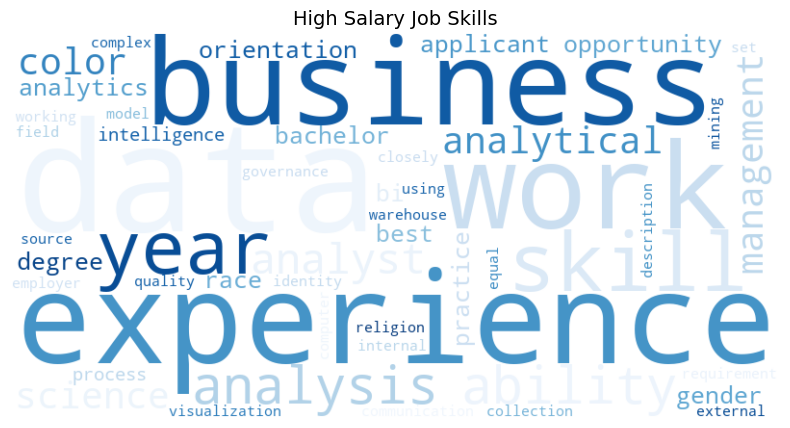

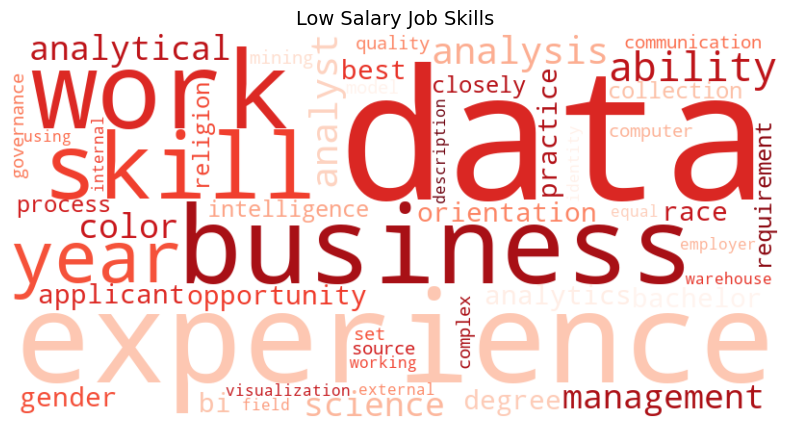

In [111]:
from collections import Counter

# **High Salary vs. Low Salary Skills Analysis**
high_salary = df[df["Salary_Avg"] > df["Salary_Avg"].median()]
low_salary = df[df["Salary_Avg"] <= df["Salary_Avg"].median()]

# **Extract only skill-related words**
vectorizer = TfidfVectorizer(stop_words="english", max_features=500, ngram_range=(1, 2))
high_X = vectorizer.fit_transform(high_salary["Cleaned_Description"])
low_X = vectorizer.fit_transform(low_salary["Cleaned_Description"])

high_terms = vectorizer.get_feature_names_out()
low_terms = vectorizer.get_feature_names_out()

# **Count the most common skills**
high_freq_words = Counter(" ".join(high_terms).split()).most_common(50)
low_freq_words = Counter(" ".join(low_terms).split()).most_common(50)

high_words = " ".join([word for word, freq in high_freq_words])
low_words = " ".join([word for word, freq in low_freq_words])

# **Generate the word cloud for high-salary skills**
high_wc = WordCloud(width=800, height=400, background_color="white", colormap="Blues").generate(high_words)

# **Generate the word cloud for low-salary skills**
low_wc = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(low_words)

# **Plot the word cloud for high-salary skills**
plt.figure(figsize=(10, 5))
plt.imshow(high_wc, interpolation="bilinear")
plt.axis("off")
plt.title("High Salary Job Skills", fontsize=14)
plt.show()

# **Plot the word cloud for low-salary skills**
plt.figure(figsize=(10, 5))
plt.imshow(low_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Low Salary Job Skills", fontsize=14)
plt.show()
